In [1]:
import csv
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 10


In [42]:
n_val_trials = 1
model_val_accs = np.zeros((11, 6))

model_names = [
        "icassp-convnet", "icassp-convnet_aug-all", 
         "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
         "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
         "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",]
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)

    for test_unit_id in range(6):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        best_trial_ids = np.argsort(val_accs)[::-1]
        best_trial_ids = best_trial_ids[:n_val_trials]

        for trial_id in best_trial_ids:

            trial_str = "trial-" + str(trial_id)
            fns, fps, tns, tps, accs = [], [], [], [], []
            validation_units = localmodule.fold_units()[test_unit_id][2]

            for val_unit_str in validation_units:

                trial_dir = os.path.join(
                    test_unit_dir, trial_str)
                predictions_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + val_unit_str,
                    "clip-predictions.csv"
                ])
                prediction_path = os.path.join(
                    trial_dir, predictions_name)

                # Load prediction.
                with open(prediction_path, 'r') as f:
                    reader = csv.reader(f)
                    rows = list(reader)
                rows = [",".join(row) for row in rows]
                rows = rows[1:]
                rows = "\n".join(rows)

                # Parse rows with correct header.
                df = pd.read_csv(StringIO(rows),
                    names=[
                        "Dataset",
                        "Test unit",
                        "Prediction unit",
                        "Timestamp",
                        "Center Freq (Hz)",
                        "Augmentation",
                        "Key",
                        "Ground truth",
                        "Predicted probability"])
                y_pred = np.array(df["Predicted probability"])
                y_pred = (y_pred > 0.5).astype('int')

                # Load ground truth.
                y_true = np.array(df["Ground truth"])

                # Compute confusion matrix.
                tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                    y_true, y_pred).ravel()

                tns.append(tn)
                fps.append(fp)
                fns.append(fn)
                tps.append(tp)

            fn = sum(fns)
            fp = sum(fps)
            tn = sum(tns)
            tp = sum(tps)

            val_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
            model_val_accs[model_id, test_unit_id] = val_acc


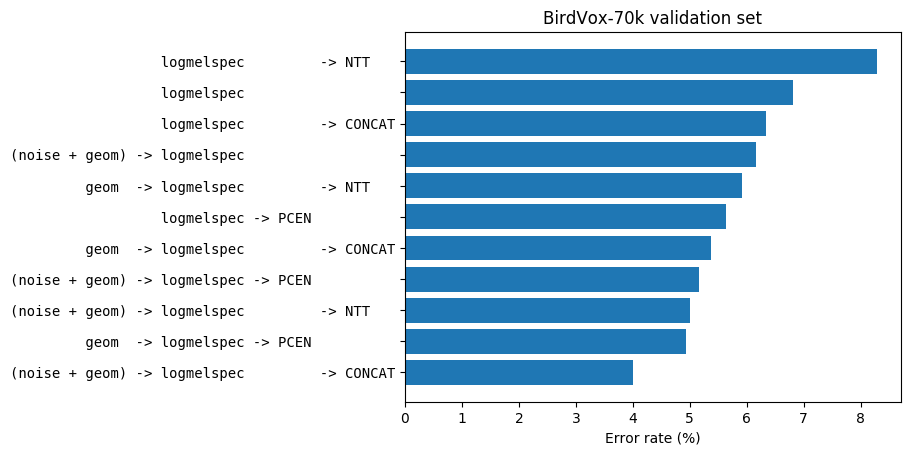

In [47]:
mean_val_accs = np.mean(model_val_accs, axis=1)
sorting_indices = np.argsort(mean_val_accs)
sorted_mean_val_accs = mean_val_accs[sorting_indices]
model_names = [
    "                  logmelspec                  ",
    "(noise + geom) -> logmelspec                  ",
    "                  logmelspec         -> NTT   ",
    "         geom  -> logmelspec         -> NTT   ",
    "(noise + geom) -> logmelspec         -> NTT   ",
    "                  logmelspec -> PCEN          ",
    "         geom  -> logmelspec -> PCEN          ",
    "(noise + geom) -> logmelspec -> PCEN          ",
    "                  logmelspec         -> CONCAT",
    "         geom  -> logmelspec         -> CONCAT",
    "(noise + geom) -> logmelspec         -> CONCAT"]
sorted_model_names = [model_names[i] for i in sorting_indices]


plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(range(11), 100 - sorted_mean_val_accs)
ax.set_yticks(range(11))
ax.set_yticklabels(sorted_model_names)
plt.setp(ax.get_yticklabels(), family="monospace")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Error rate (%)')
ax.set_title('BirdVox-70k validation set')

plt.show()

In [53]:
n_val_trials = 1
model_val_accs = np.zeros((11, 6))

model_names = [
    "pcen-add-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    "pcen-add-convnet",
    "pcen-ntt-convnet_aug-all",
    "pcen-ntt-convnet_aug-all-but-noise",
    "pcen-ntt-convnet"]
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)

    for test_unit_id in range(6):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        best_trial_ids = np.argsort(val_accs)[::-1]
        best_trial_ids = best_trial_ids[:n_val_trials]

        for trial_id in best_trial_ids:

            trial_str = "trial-" + str(trial_id)
            fns, fps, tns, tps, accs = [], [], [], [], []
            validation_units = localmodule.fold_units()[test_unit_id][2]
            print(model_name, test_unit_str, trial_str)
            
    print("")

pcen-add-convnet_aug-all unit01 trial-9
pcen-add-convnet_aug-all unit02 trial-5
pcen-add-convnet_aug-all unit03 trial-5
pcen-add-convnet_aug-all unit05 trial-4
pcen-add-convnet_aug-all unit07 trial-0
pcen-add-convnet_aug-all unit10 trial-6

pcen-add-convnet_aug-all-but-noise unit01 trial-4
pcen-add-convnet_aug-all-but-noise unit02 trial-1
pcen-add-convnet_aug-all-but-noise unit03 trial-0
pcen-add-convnet_aug-all-but-noise unit05 trial-9
pcen-add-convnet_aug-all-but-noise unit07 trial-9
pcen-add-convnet_aug-all-but-noise unit10 trial-8

pcen-add-convnet unit01 trial-6
pcen-add-convnet unit02 trial-8
pcen-add-convnet unit03 trial-2
pcen-add-convnet unit05 trial-8
pcen-add-convnet unit07 trial-6
pcen-add-convnet unit10 trial-2

pcen-ntt-convnet_aug-all unit01 trial-9
pcen-ntt-convnet_aug-all unit02 trial-7
pcen-ntt-convnet_aug-all unit03 trial-8
pcen-ntt-convnet_aug-all unit05 trial-2
pcen-ntt-convnet_aug-all unit07 trial-2
pcen-ntt-convnet_aug-all unit10 trial-3

pcen-ntt-convnet_aug-all